## 1. Load dataset

In [1]:
import numpy as np

In [2]:
def create_three_circles(n_points_per_circle=100, noise=0.1, seed=42):
    np.random.seed(seed)
    
    # Radii for the three circles
    radii = [1.0, 2.0, 3.0]
    
    # Generate points
    X = []
    y = []
    
    for i, radius in enumerate(radii):
        theta = np.linspace(0, 2*np.pi, n_points_per_circle) + \
                np.random.normal(0, noise, n_points_per_circle)
        
        # Generate points on circle
        x = radius * np.cos(theta) + np.random.normal(0, noise, n_points_per_circle)
        y_coord = radius * np.sin(theta) + np.random.normal(0, noise, n_points_per_circle)
        
        X.extend(np.column_stack([x, y_coord]))
        y.extend([i] * n_points_per_circle)
    
    return np.array(X), np.array(y)


In [3]:

from sklearn.datasets import make_moons

graph_number = 10
single_view_graph_X = []
# Generate two-moon datasets
# class_number = 2
# for i in range(graph_number):
#     X, y = make_moons(n_samples=100, noise=0.13, random_state=i+10)
#     single_view_graph_X.append(X)
    
# Generate three_circles datasets
class_number = 3
for i in range(graph_number):
    X, y = create_three_circles(n_points_per_circle=100, noise=0.13, seed=i+10)
    single_view_graph_X.append(X)

## 2. Algorithm

### 2.1 Single View Graph Learning

In [4]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from tqdm import tqdm 
from scipy import linalg

def compute_laplacian(S):
    S_sym = (S.T + S) / 2  # Compute symmetric part
    D = np.diag(S_sym.sum(axis=1))  # Compute diagonal matrix D
    L = D - S_sym  # Compute Laplacian matrix
    return L

def update_Q(L, c):
    L = (L + L.T) / 2
    eigenvals, eigenvecs = linalg.eigh(L)
    Q = eigenvecs[:, :c]
    return Q


def update_S(Q, beta):
    n = Q.shape[0]
    S = np.zeros((n, n))
    
    # Calculate pairwise distances (g_ij matrix)
    G = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            G[i, j] = np.sum((Q[i] - Q[j]) ** 2)
    
    # Update each column of S independently
    for j in range(n):
        g_j = G[:, j]  # Get j-th column of G
        
        # Binary search for eta that satisfies sum(s_j) = 1
        left, right = 0, np.max(g_j)/(2*beta)
        
        while right - left > 1e-10:
            eta = (left + right) / 2
            s_j = np.maximum(0, -g_j/(2*beta) + eta)
            sum_s = np.sum(s_j)
            
            if sum_s < 1:
                left = eta
            else:
                right = eta
        
        # Final update for j-th column using found eta
        S[:, j] = np.maximum(0, -g_j/(2*beta) + eta)
    
    return S


def make_single_view_graph(single_view_graph_X, class_number, default_beta=1.0):
    
    single_view_graph = []
    
    for i in tqdm(range(len(single_view_graph_X))):
        
        # init
        beta = default_beta
        S = update_S(single_view_graph_X[i], beta)
        L = compute_laplacian(S)
        Q = update_Q(L, class_number)

        for j in range(100):
            S = update_S(Q, beta)
            L = compute_laplacian(S)
            Q = update_Q(L, class_number)

            L_rank = np.linalg.matrix_rank(L)
            # print("L_rank",L_rank, "beta", beta)
            if L_rank == X.shape[0] - class_number:
                tqdm.write(f"{i+1}th graph end at {j}th iteration, L's rank is {L_rank}")
                break
            elif L_rank > X.shape[0] - class_number:
                beta *= 0.9 
            else:
                beta *= 1.1
                
        single_view_graph.append(S)
        
    return single_view_graph


In [5]:
single_view_graph = make_single_view_graph(single_view_graph_X, class_number)

 10%|█         | 1/10 [00:04<00:37,  4.21s/it]

1th graph end at 7th iteration, L's rank is 297


 20%|██        | 2/10 [00:09<00:37,  4.64s/it]

2th graph end at 9th iteration, L's rank is 297


 30%|███       | 3/10 [00:15<00:36,  5.22s/it]

3th graph end at 11th iteration, L's rank is 297


 40%|████      | 4/10 [00:19<00:29,  4.89s/it]

4th graph end at 8th iteration, L's rank is 297


 50%|█████     | 5/10 [00:24<00:25,  5.09s/it]

5th graph end at 10th iteration, L's rank is 297


 60%|██████    | 6/10 [00:29<00:19,  4.80s/it]

6th graph end at 8th iteration, L's rank is 297


 70%|███████   | 7/10 [00:33<00:14,  4.71s/it]

7th graph end at 9th iteration, L's rank is 297


 80%|████████  | 8/10 [00:37<00:09,  4.53s/it]

8th graph end at 8th iteration, L's rank is 297


 90%|█████████ | 9/10 [00:42<00:04,  4.65s/it]

9th graph end at 10th iteration, L's rank is 297


100%|██████████| 10/10 [00:47<00:00,  4.70s/it]

10th graph end at 8th iteration, L's rank is 297


### 2.2 Global Graph Learning

In [9]:
def init_W(single_view_graph):
    W = [np.full(single_view_graph[0].shape, 1/len(single_view_graph))] * len(single_view_graph)
    return W

def init_A(single_view_graph, W):
    A = np.sum(single_view_graph, axis=0) * W[0]
    return A

def init_P(A,c):
    L = compute_laplacian(A)
    P = update_Q(L, c)
    return P


def update_A(P, w_list, s_list, gamma=1.0):

    n = P.shape[0]
    A = np.zeros((n, n))
    
    # Compute hj for each column
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            H[i, j] = np.sum((P[i] - P[j])**2)  # ||p_i - p_j||^2
    
    # For each column j
    for j in range(n):
        # Compute the weighted sum of similarity matrices for column j
        weighted_sum = np.zeros(n)
        for v in range(len(w_list)):
            weighted_sum += w_list[v][:, j] * s_list[v][:, j]
        
        # Compute b_j = hj - sum_v w_j^(v) * s_j^(v)
        b_j = (gamma/2) *H[:, j] - weighted_sum
        
        # Update each column of S independently
        for j in range(n):
            
            # Binary search for eta that satisfies sum(s_j) = 1
            left, right = 0, np.max(b_j)
            
            while right - left > 1e-10:
                eta = (left + right) / 2
                s_j = np.maximum(0, -b_j + eta)
                sum_s = np.sum(s_j)
                
                if sum_s < 1:
                    left = eta
                else:
                    right = eta
            
            # Final update for j-th column using found eta
            A[:, j] = np.maximum(0, -b_j + eta)
    
    return A


def update_P(L, c):
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    Q = eigenvectors[:, :c]
    return Q


def project_simplex(v):
    n = len(v)
    
    # Sort v in descending order
    u = np.sort(v)[::-1]
    
    # Compute the threshold
    cssv = np.cumsum(u) - 1
    ind = np.arange(n) + 1
    cond = u - cssv / ind > 0
    
    if not np.any(cond):  # Handle the case where all elements are negative
        return np.ones(n) / n
    
    rho = ind[cond][-1]
    
    # Compute the Lagrange multiplier
    theta = cssv[rho-1] / rho
    
    # Compute the projection
    x = np.maximum(v - theta, 0)
    
    return x

def compute_W(a, s_list):
    n = a.shape[0]
    nv = len(s_list)  # Number of views
    
    # Initialize weight matrices
    w_list = [np.zeros((n, n)) for _ in range(nv)]
    
    # For each column j
    for j in range(n):
        # Construct Z_j matrix where each column corresponds to a view
        # and each row corresponds to a sample
        Z_j = np.zeros((n, nv))
        for v in range(nv):
            Z_j[:, v] = a[:, j] - s_list[v][:, j]
        
        # Compute Z_j^T * Z_j
        ZTZ = np.dot(Z_j.T, Z_j)
        
        # Handle potential numerical issues with matrix inversion
        try:
            # Add small regularization to ensure invertibility
            epsilon = 1e-8
            ZTZ_reg = ZTZ + epsilon * np.eye(nv)
            
            # Compute the inverse of Z_j^T * Z_j
            ZTZ_inv = np.linalg.inv(ZTZ_reg)
            
            # Compute w_j according to the formula
            ones = np.ones(nv)
            denominator = np.dot(ones, np.dot(ZTZ_inv, ones))
            
            if np.abs(denominator) < 1e-10:  # Avoid division by zero
                w_j = np.ones(nv) / nv  # Equal weights if denominator is close to zero
            else:
                w_j = np.dot(ZTZ_inv, ones) / denominator
        except np.linalg.LinAlgError:
            # If matrix is still singular, use equal weights
            w_j = np.ones(nv) / nv
        
        # Handle numerical issues: ensure weights are non-negative
        if np.any(w_j < 0):
            # Project to the simplex if there are negative weights
            w_j = project_simplex(w_j)
        
        # Ensure the constraint sum(w_j) = 1 is satisfied exactly
        w_j = w_j / np.sum(w_j)
        
        # Store the weights in the weight matrices
        for v in range(nv):
            w_list[v][:, j] = w_j[v]
            
    return w_list

def make_global_graph(single_view_graph, class_number, default_gamma=1.0):
    
    # init
    W = init_W(single_view_graph)
    A = init_A(single_view_graph, W)
    P = init_P(A, class_number)
    gamma = default_gamma
    
    for j in tqdm(range(1)):
        A = update_A(P, W, single_view_graph)
        L = compute_laplacian(A)
        P = update_P(L, class_number)
        W = compute_W(A, single_view_graph)

        tqdm.write(f"iteration: {j}, L_rank: {np.linalg.matrix_rank(L)}, gamma: {gamma}")
        # print(sum(W[0][:,0]))
        L_rank = np.linalg.matrix_rank(L)
        if L_rank == X.shape[0] - class_number:
            tqdm.write(f"end at {j}th iteration, L's rank is {L_rank}")
            break
        elif L_rank < X.shape[0] - class_number:
            gamma *= 0.9 
        else:
            gamma *= 1.1
        
    return A

In [10]:
# global_graph = make_global_graph(single_view_graph, class_number)
global_graph = make_global_graph([single_view_graph[1],single_view_graph[2]], class_number)

100%|██████████| 1/1 [00:12<00:00, 12.23s/it]

iteration: 0, L_rank: 299, gamma: 1.0


### 2.3 Cluster by Laplacian matrix

In [15]:
import numpy as np
from sklearn.cluster import SpectralClustering
def cluster_from_similarity(similarity_matrix, n_clusters):

    # Initialize spectral clustering
    clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',  # Use pre-computed similarity matrix
        random_state=42
    )
    
    # Fit and predict clusters
    labels = clustering.fit_predict(similarity_matrix)
    return labels

# get clustering results
single_view_graph_labels = []
for i in range(len(single_view_graph)):
    single_view_graph_labels.append(cluster_from_similarity(single_view_graph[i], class_number))

import numpy as np
np.set_printoptions(threshold=np.inf)
# print(single_view_graph[0])

global_graph_labels = cluster_from_similarity(global_graph, class_number)
print(single_view_graph_labels[0])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converte

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


# 3. Visualization

In [16]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from matplotlib.colors import ListedColormap


import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from matplotlib.colors import ListedColormap


def plot_clusters_multi(X_list, labels_list, view_graph_list, max_neighbour=10):
    # Ensure the input lists are of the same length
    assert len(X_list) == len(labels_list), "X_list and labels_list must have the same number of elements"
    assert len(X_list) == len(view_graph_list), "X_list and view_graph_list must have the same number of elements"
    
    n_datasets = len(X_list)
    rows = int(np.ceil(np.sqrt(n_datasets)))
    cols = int(np.ceil(n_datasets / rows))
    
    plt.figure(figsize=(6 * cols, 4 * rows))
    
    # Define a set of distinct colors that can be used for different classes
    # This color palette can be extended as needed
    color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']
    
    for idx in range(n_datasets):
        X = X_list[idx]
        view_graph = view_graph_list[idx]
        n = X.shape[0]
        labels = labels_list[idx]
        
        # Get unique classes in this dataset's labels
        unique_classes = np.unique(labels)
        n_classes = len(unique_classes)
        
        # Create a colormap specific to this dataset based on the number of classes
        dataset_colors = color_palette[:n_classes]
        cmap = ListedColormap(dataset_colors)
        
        # Create subplot
        plt.subplot(rows, cols, idx + 1)
        
        # Plot data points
        scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=cmap, s=80, zorder=2)
        
        # Add a legend with class labels
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=dataset_colors[i], markersize=10, 
                          label=f'Class {unique_classes[i]}') 
                          for i in range(n_classes)]
        plt.legend(handles=legend_elements, loc='upper right')
        
        # Plot intra-cluster connections
        for i in range(n):
            for j in range(i + 1, n):
                if view_graph[i, j] > (2/n) and view_graph[j, i] > (2/n):
                    plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]],
                             color='#00FF00', alpha=1, zorder=1000)
        
        plt.title(f'Graph {idx} ({n_classes} classes)')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
    
    plt.tight_layout()
    plt.show()


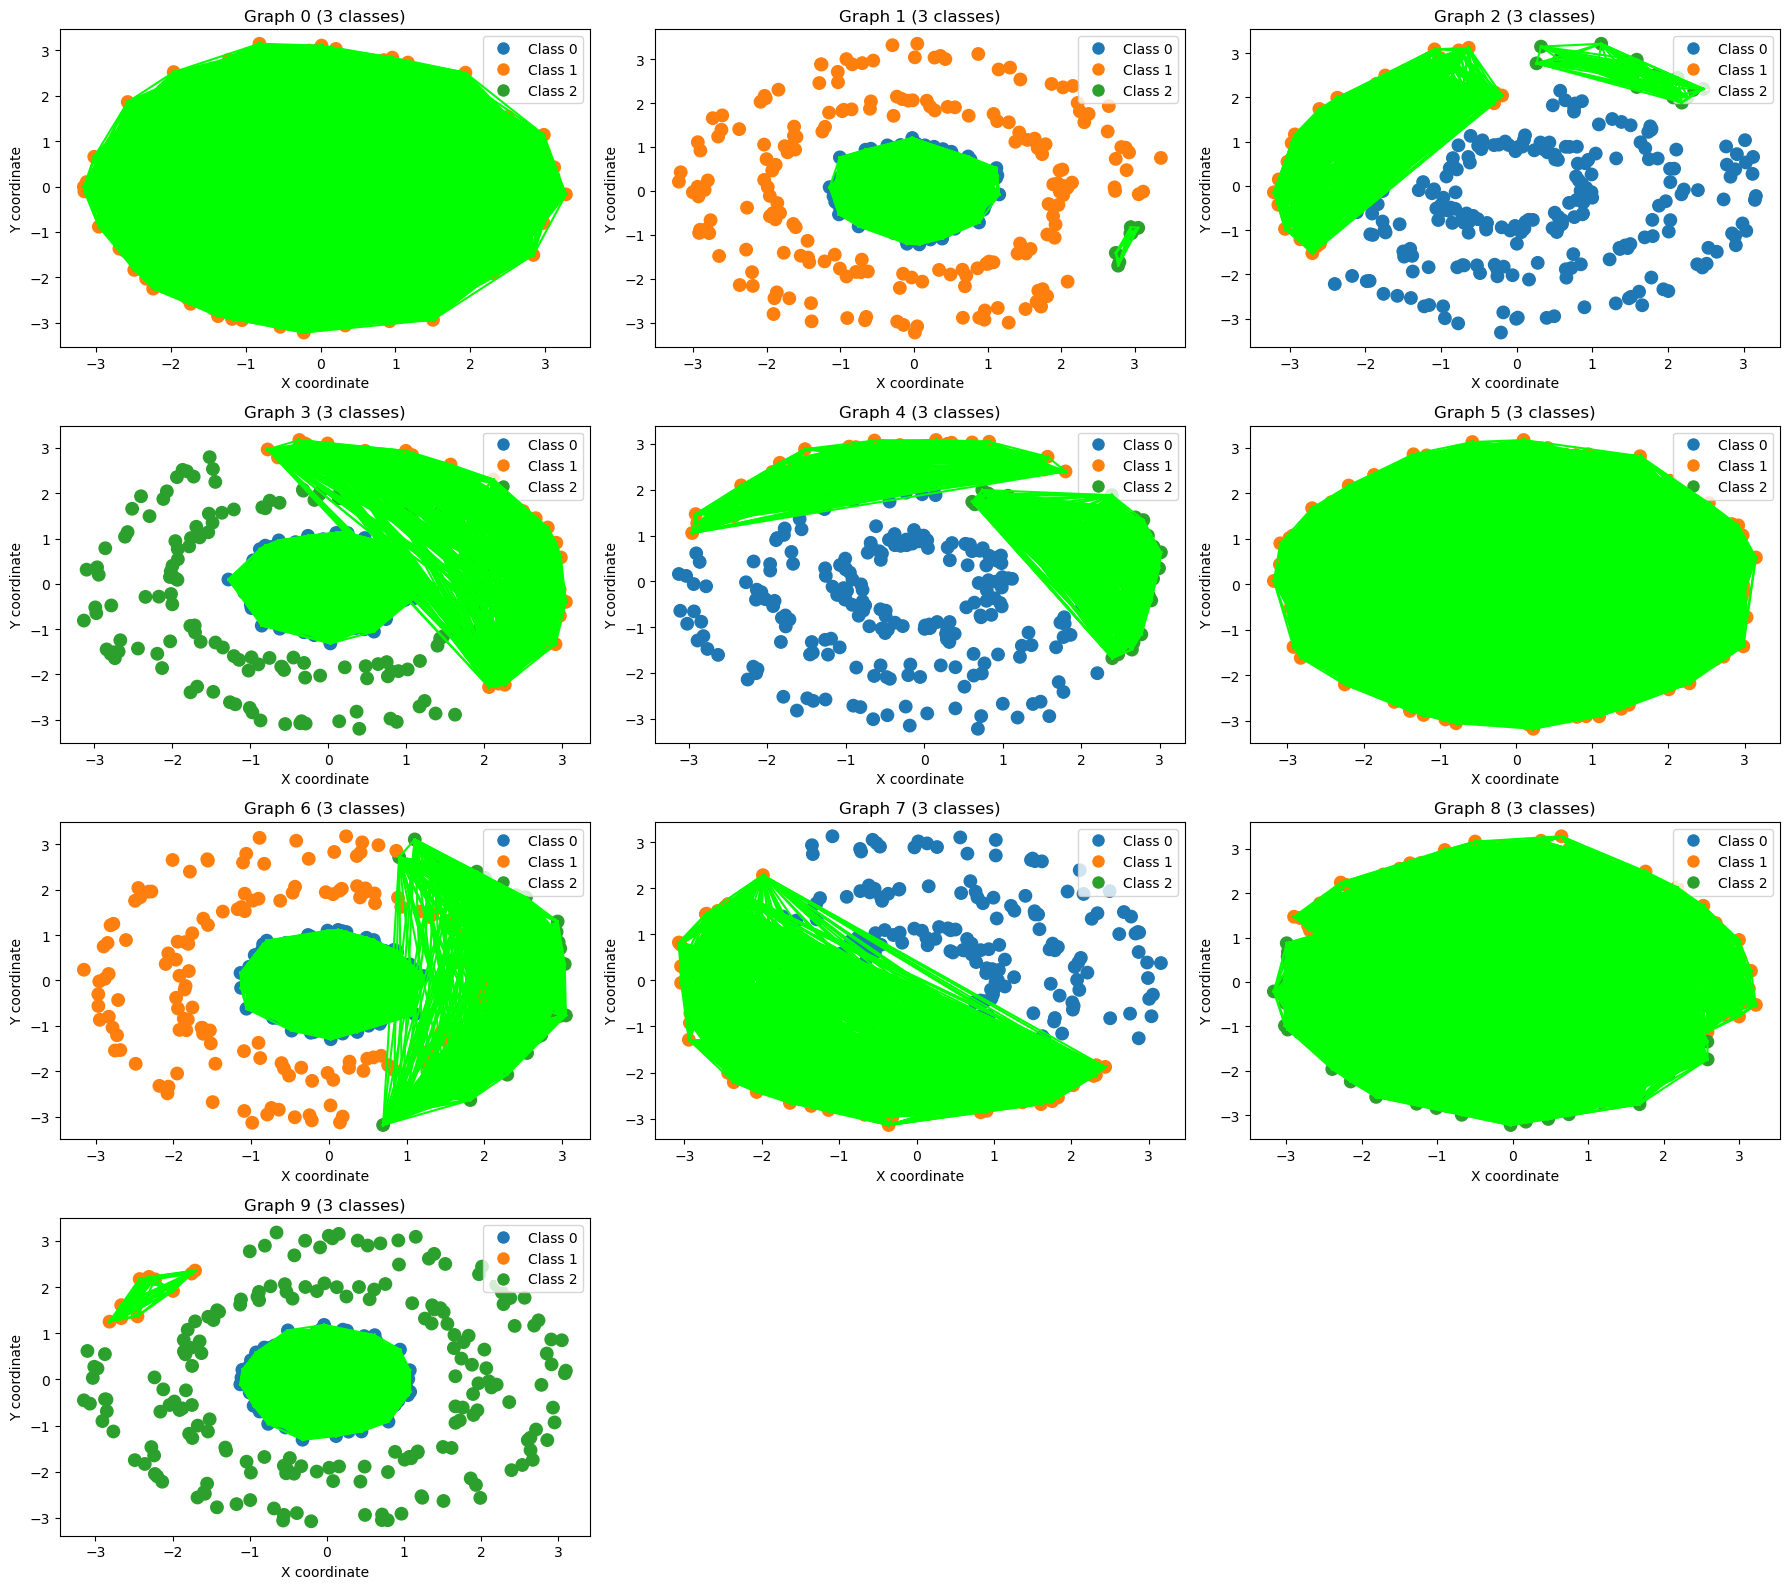

In [17]:
plot_clusters_multi(single_view_graph_X, single_view_graph_labels, single_view_graph)

In [ ]:
plot_clusters_multi([single_view_graph_X[0]], [global_graph_labels], [global_graph]) 

# 4. Evaluation

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix

def cluster_accuracy(y_true, y_pred):
    acc = np.mean(y_pred == y_true)
    return acc

def purity_score(y_true, y_pred):
    contingency = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

def pairwise_precision_recall_fscore(y_true, y_pred):

    def get_pairs(labels):
        pairs = set()
        for label in np.unique(labels):
            indices = np.where(labels == label)[0]
            for i in range(len(indices)):
                for j in range(i + 1, len(indices)):
                    pairs.add((indices[i], indices[j]))
        return pairs

    true_pairs = get_pairs(y_true)
    pred_pairs = get_pairs(y_pred)
    
    tp = len(true_pairs & pred_pairs)
    fp = len(pred_pairs - true_pairs)
    fn = len(true_pairs - pred_pairs)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    
    return precision, recall, f_score

def evaluate_clustering(y_true, y_pred):
    
    # remapping 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    assert y_true.shape == y_pred.shape

    labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    cost_matrix = -contingency_matrix(y_true, y_pred)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    best_mapping = {pred_labels[col]: labels[row] for row, col in zip(row_ind, col_ind)}

    y_pred_mapped = np.array([best_mapping[label] for label in y_pred])

    # evaluate
    acc = cluster_accuracy(y_true, y_pred_mapped)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    purity = purity_score(y_true, y_pred_mapped)
    precision, recall, f_score = pairwise_precision_recall_fscore(y_true, y_pred_mapped)
    ari = adjusted_rand_score(y_true, y_pred_mapped)

    return {
        "ACC": acc,
        "NMI": nmi,
        "Purity": purity,
        "Precision": precision,
        "Recall": recall,
        "F-score": f_score,
        "ARI": ari
    }


# test
metrics = evaluate_clustering(y, global_graph_labels)
print(metrics)
